# Plot Customization

In [131]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc, classification_report


## 30-day Model

In [132]:
xgb_model_30d = xgb.XGBClassifier()
xgb_model_30d.load_model('30d_best_model.json')

In [133]:
training_data_imputed_df = pd.read_csv("training_data_imputed_simple_TRAIN.csv.gz") 
train_df, val_df = train_test_split(training_data_imputed_df, test_size=0.2, random_state=1)

X_val = val_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y_val_30 = val_df['cdiff_30d_flag']

y_val_30.value_counts()

cdiff_30d_flag
0.0    17027
1.0     1037
Name: count, dtype: int64

## AUROC Curves

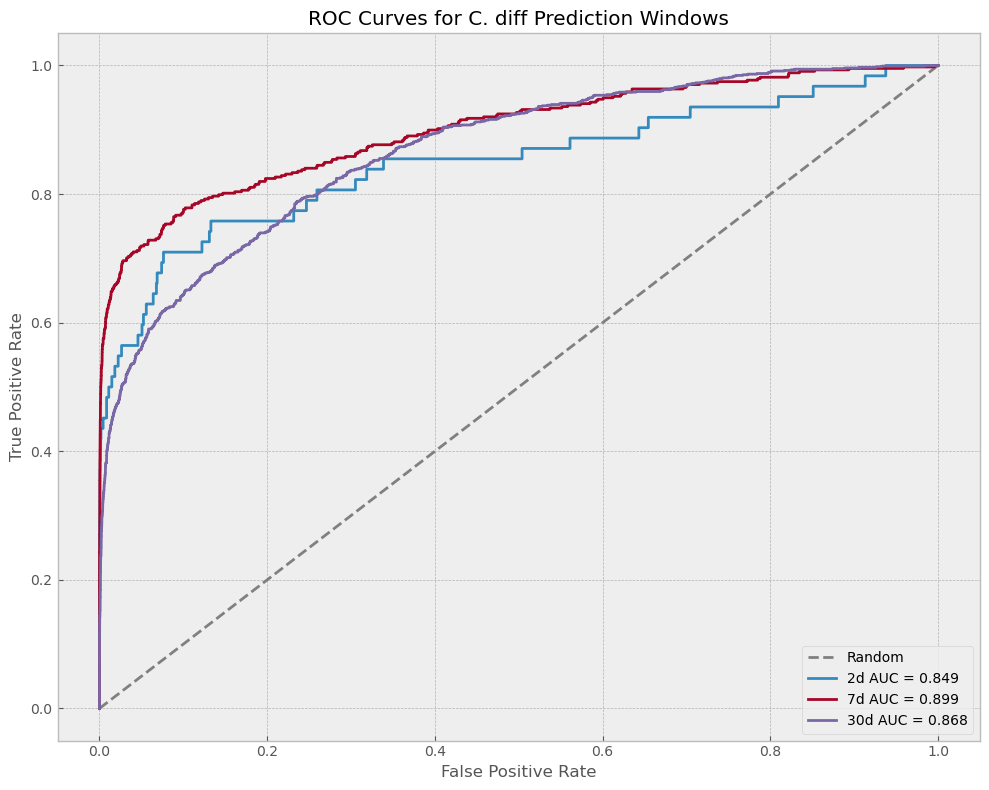

In [134]:
windows = ['2d', '7d', '30d']
plt.figure(figsize=(10, 8))
plt.style.use('bmh')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random")
for window in windows:
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(f'{window}_best_model.json')
    y_true = val_df[f'cdiff_{window}_flag']

    y_val_pred = xgb_model.predict(X_val)
    y_val_prob = xgb_model.predict_proba(X_val)[:, 1]  

    fpr, tpr, thresholds = roc_curve(y_true, y_val_prob)
    auc_score = roc_auc_score(y_true, y_val_prob)

    plt.step(fpr, tpr, label=f"{window} AUC = {auc_score:.3f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for C. diff Prediction Windows")
    plt.legend(loc="lower right")
    plt.tight_layout()
plt.show()

## AUPRC

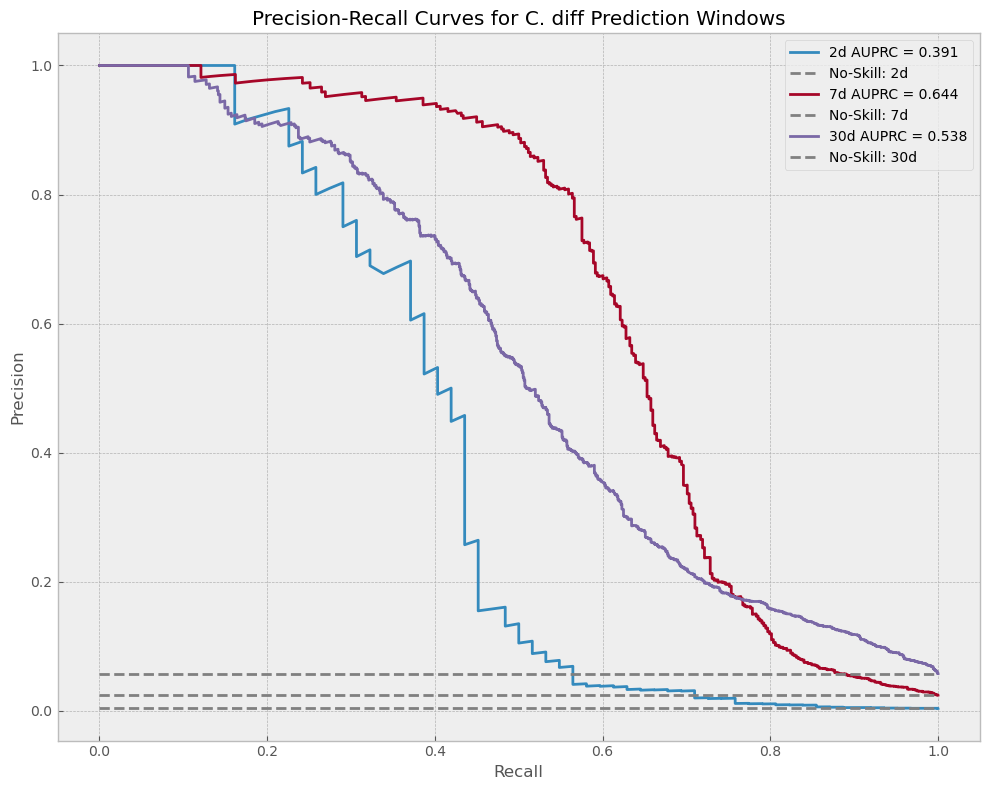

In [139]:
windows = ['2d', '7d', '30d']
plt.figure(figsize=(10, 8))
plt.style.use('bmh')
for window in windows:
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(f'{window}_best_model.json')
    y_true = val_df[f'cdiff_{window}_flag']

    y_val_pred = xgb_model.predict(X_val)
    y_val_prob = xgb_model.predict_proba(X_val)[:, 1]  


    precision, recall, thresholds = precision_recall_curve(y_true, y_val_prob)
    auprc_score = average_precision_score(y_true, y_val_prob)

    case_rate = y_true.sum() / len(y_true)

    plt.plot(recall, precision, label=f"{window} AUPRC = {auprc_score:.3f}")
    plt.plot([0, 1], [case_rate, case_rate], linestyle='--', color='gray', label=f"No-Skill: {window}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curves for C. diff Prediction Windows")
    plt.legend(loc="upper right")
    plt.tight_layout()
plt.show()

## Feature Importance

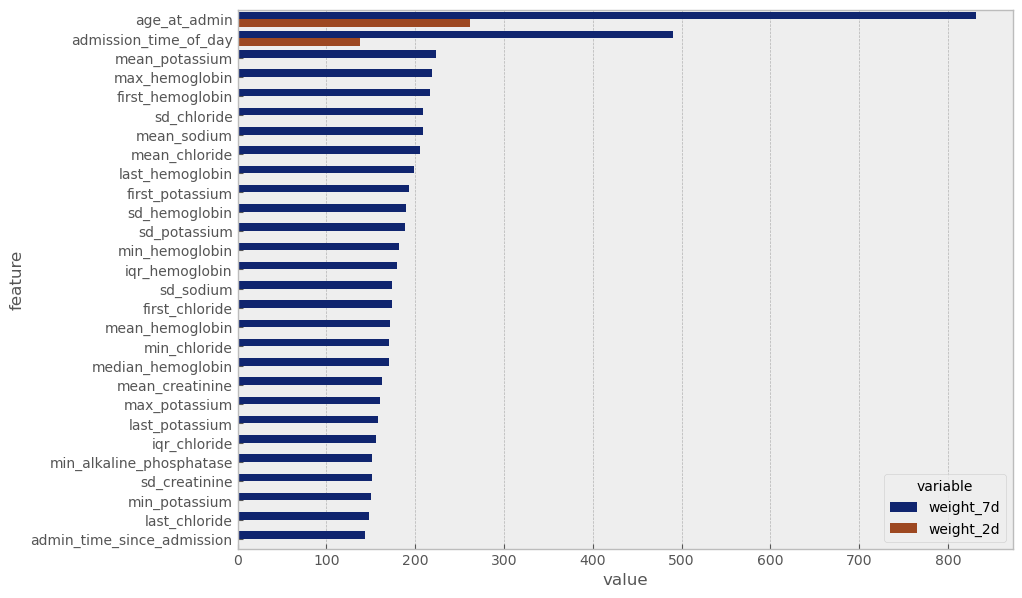

In [162]:
windows = ['2d', '7d', '30d']
feature_importances_df = pd.DataFrame({'feature': xgb_model.feature_names_in_})
# plt.figure(figsize=(10, 7))
# plt.style.use('bmh')
for window in windows:
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(f'{window}_best_model.json')
    y_true = val_df[f'cdiff_{window}_flag']

    window_df = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='weight').items(), columns=['feature', f'weight_{window}']).sort_values([f'weight_{window}'])

    feature_importances_df = feature_importances_df.merge(window_df, on='feature', how='outer')

feature_importances_long = pd.melt(feature_importances_df, id_vars=['feature'], value_vars=['weight_2d', 'weight_7d', 'weight_30d'])
feature_importances_long = feature_importances_long.sort_values(['value'], ascending=False).head(30)
plt.figure(figsize=(10, 7))
plt.style.use('bmh')
sns.barplot(
    data=feature_importances_long,
    y="feature", x="value", hue="variable",
     palette="dark"
)
plt.show()
# g.set_xticklabels(g.get_xticklabels(), rotation=45)
# g.despine(left=True)
# g.set_axis_labels("Window", "Feature importance")
# g.legend.set_title("")

In [161]:
feature_importances_long

,feature,variable,value
188,age_at_admin,weight_7d,831.0
183,admission_time_of_day,weight_7d,490.0
23,age_at_admin,weight_2d,262.0
271,mean_potassium,weight_7d,224.0
255,max_hemoglobin,weight_7d,219.0
212,first_hemoglobin,weight_7d,217.0
321,sd_chloride,weight_7d,209.0
272,mean_sodium,weight_7d,209.0
265,mean_chloride,weight_7d,205.0
241,last_hemoglobin,weight_7d,199.0


<Figure size 1200x800 with 0 Axes>

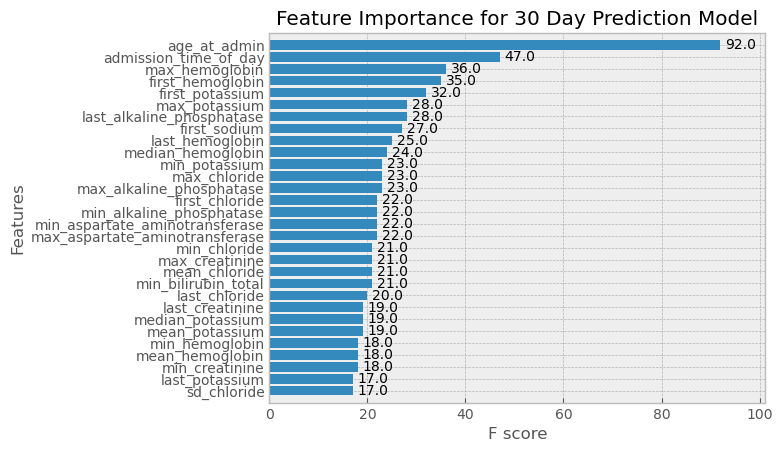

In [66]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model_30d, max_num_features=30, height=0.8)
plt.title('Feature Importance for 30 Day Prediction Model')
plt.show()